# Tom and Jerry Simulation

Solving with random Tom...
Iter 0, delta = 8.000e-01
Iter 1, delta = 7.200e-01
Iter 2, delta = 6.400e-01
Iter 3, delta = 2.833e-01
Iter 4, delta = 1.632e-01
Iter 5, delta = 1.249e-01
Iter 6, delta = 1.050e-01
Iter 7, delta = 4.589e-02
Iter 8, delta = 3.180e-02
Iter 9, delta = 2.360e-02
Iter 10, delta = 1.952e-02
Iter 11, delta = 1.680e-02
Iter 12, delta = 1.401e-02
Iter 13, delta = 1.172e-02
Iter 14, delta = 9.563e-03
Iter 15, delta = 7.836e-03
Iter 16, delta = 6.322e-03
Iter 17, delta = 5.113e-03
Iter 18, delta = 4.095e-03
Iter 19, delta = 3.299e-03
Iter 20, delta = 2.642e-03
Iter 21, delta = 2.124e-03
Iter 22, delta = 1.706e-03
Iter 23, delta = 1.378e-03
Iter 24, delta = 1.112e-03
Iter 25, delta = 9.105e-04
Iter 26, delta = 7.476e-04
Iter 27, delta = 6.148e-04
Iter 28, delta = 5.056e-04
Iter 29, delta = 4.161e-04
Iter 30, delta = 3.425e-04
Iter 31, delta = 2.821e-04
Iter 32, delta = 2.323e-04
Iter 33, delta = 1.914e-04
Iter 34, delta = 1.577e-04
Iter 35, delta = 1.299e-04
Iter 36, de

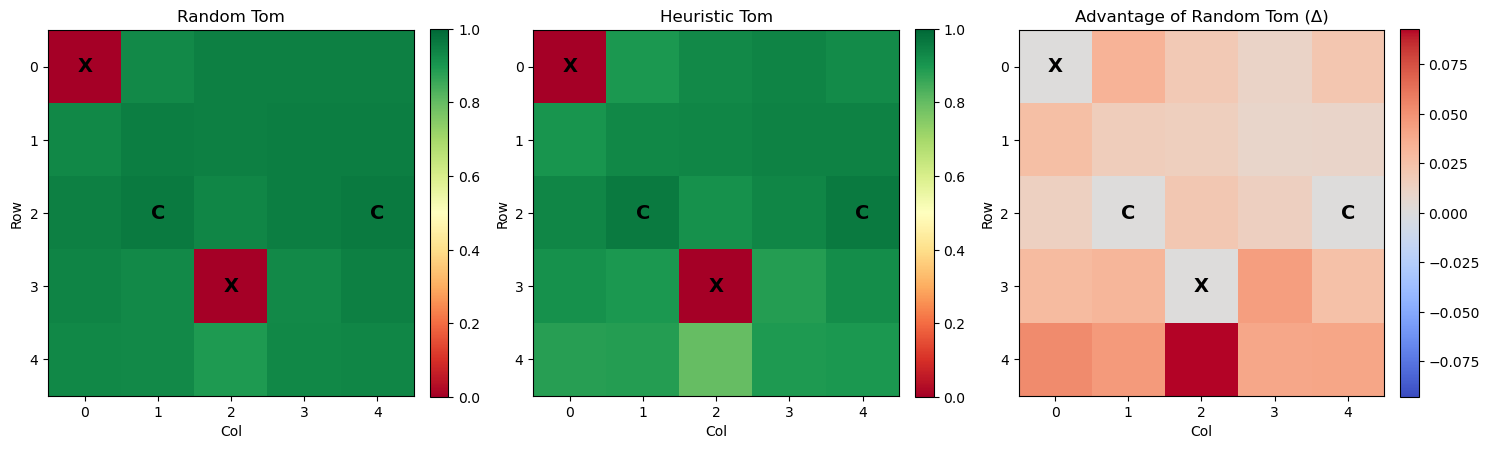


Simulating trajectories for histogram data...
Rendering state-visit histograms...


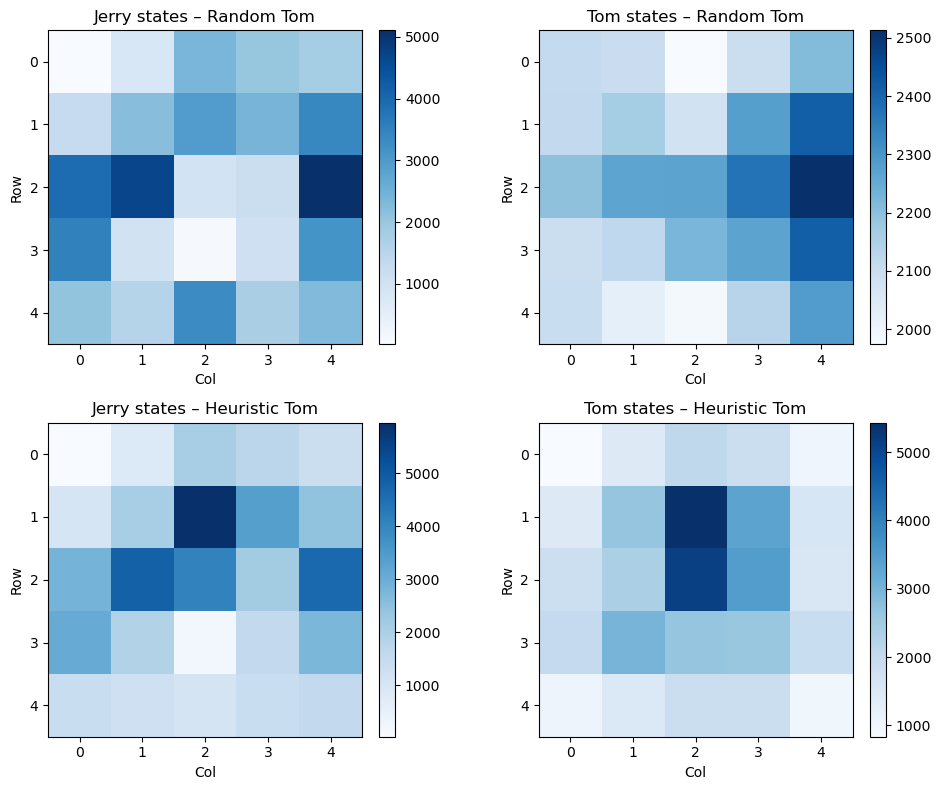

In [1]:
# %pip -q install -U pip
# %pip -q install -U numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Grid setup and indexing
# -----------------------------
GRID_SIZE = 5
NUM_CELLS = GRID_SIZE * GRID_SIZE

def rc_to_pos(r, c):
    return r * GRID_SIZE + c

def pos_to_rc(pos):
    return divmod(pos, GRID_SIZE)

# Environment layout: traps and cheese (code coordinates: row 0 = top)
TRAP_CELLS = {
    rc_to_pos(0, 0),  # top-left
    rc_to_pos(3, 2),  # lower trap
}
CHEESE_CELLS = {
    rc_to_pos(2, 1),  # left cheese
    rc_to_pos(2, 4),  # right cheese
}

is_trap = np.zeros(NUM_CELLS, dtype=bool)
is_cheese = np.zeros(NUM_CELLS, dtype=bool)
for p in TRAP_CELLS:
    is_trap[p] = True
for p in CHEESE_CELLS:
    is_cheese[p] = True

# -----------------------------
# Actions and single-agent dynamics
# -----------------------------
NORTH, SOUTH, EAST, WEST = 0, 1, 2, 3
ACTIONS = [NORTH, SOUTH, EAST, WEST]
NUM_ACTIONS = len(ACTIONS)

ACTION_DELTAS = {
    NORTH: (-1, 0),
    SOUTH: ( 1, 0),
    EAST:  ( 0, 1),
    WEST:  ( 0,-1),
}
LEFT_OF = {NORTH: WEST, SOUTH: EAST, EAST: NORTH, WEST: SOUTH}
RIGHT_OF = {NORTH: EAST, SOUTH: WEST, EAST: SOUTH, WEST: NORTH}

def move_cell(pos, action):
    """Deterministic move; if off-grid, stay."""
    r, c = pos_to_rc(pos)
    dr, dc = ACTION_DELTAS[action]
    nr, nc = r + dr, c + dc
    if 0 <= nr < GRID_SIZE and 0 <= nc < GRID_SIZE:
        return rc_to_pos(nr, nc)
    else:
        return pos

def jerry_transition_probs(jerry_pos, action):
    """
    Jerry: 0.8 intended direction, 0.1 left, 0.1 right.
    Returns dict[next_jerry_pos] = prob.
    """
    intended = action
    left = LEFT_OF[action]
    right = RIGHT_OF[action]
    moves = [intended, left, right]
    probs = [0.8, 0.1, 0.1]
    out = {}
    for a, p in zip(moves, probs):
        nxt = move_cell(jerry_pos, a)
        out[nxt] = out.get(nxt, 0.0) + p
    return out

# -----------------------------
# Tom policies
# -----------------------------
def tom_transition_probs_random(tom_pos):
    """Tom: uniform random N,S,E,W."""
    out = {}
    for a in ACTIONS:
        nxt = move_cell(tom_pos, a)
        out[nxt] = out.get(nxt, 0.0) + 1.0 / NUM_ACTIONS
    return out

def tom_heuristic_action(tom_pos, jerry_pos):
    """
    Manhattan heuristic toward Jerry.
    Tie-breaking: if multiple actions give same min distance, break uniformly.
    """
    jr, jc = pos_to_rc(jerry_pos)
    best_actions = []
    best_dist = float('inf')
    for a in ACTIONS:
        nxt = move_cell(tom_pos, a)
        nr, nc = pos_to_rc(nxt)
        dist = abs(nr - jr) + abs(nc - jc)
        if dist < best_dist:
            best_dist = dist
            best_actions = [a]
        elif dist == best_dist:
            best_actions.append(a)
    # uniform tie-break
    return np.random.choice(best_actions) if len(best_actions) > 1 else best_actions[0]

def tom_transition_probs_heuristic(tom_pos, jerry_pos, chase_p=0.7):
    """
    Tom: chase Jerry with probability chase_p, otherwise uniform random (1 - chase_p).
    Returns dict[next_tom_pos] = prob.
    """
    chase_p = float(chase_p)
    assert 0.0 <= chase_p <= 1.0
    out = {}
    # chase branch
    best_action = tom_heuristic_action(tom_pos, jerry_pos)
    nxt = move_cell(tom_pos, best_action)
    out[nxt] = out.get(nxt, 0.0) + chase_p
    # random branch
    rand_p = (1.0 - chase_p) / NUM_ACTIONS
    for a in ACTIONS:
        nxt = move_cell(tom_pos, a)
        out[nxt] = out.get(nxt, 0.0) + rand_p
    return out

# -----------------------------
# Joint state space
# -----------------------------
NUM_STATES = NUM_CELLS * NUM_CELLS

def encode_state(jerry_pos, tom_pos):
    return jerry_pos * NUM_CELLS + tom_pos

def decode_state(s):
    j = s // NUM_CELLS
    t = s % NUM_CELLS
    return j, t

def is_bad_state(j, t):
    return is_trap[j] or (j == t)

def is_goal_state(j, t):
    return is_cheese[j]

# -----------------------------
# Joint transition with caching
# -----------------------------
_TRANSITION_CACHE = {}

def joint_transition(s, a, tom_policy='random', chase_p=0.7):
    """
    Return dict[next_state] = prob under given action and Tom policy.
    tom_policy: 'random' or 'heuristic'; chase_p only used for 'heuristic'.
    """
    key = (s, a, tom_policy, round(float(chase_p), 6))
    if key in _TRANSITION_CACHE:
        return _TRANSITION_CACHE[key]

    j, t = decode_state(s)
    if is_goal_state(j, t) or is_bad_state(j, t):
        out = {s: 1.0}
        _TRANSITION_CACHE[key] = out
        return out

    out = {}
    j_probs = jerry_transition_probs(j, a)
    if tom_policy == 'random':
        t_probs = tom_transition_probs_random(t)
    elif tom_policy == 'heuristic':
        t_probs = tom_transition_probs_heuristic(t, j, chase_p=chase_p)
    else:
        raise ValueError(f"Unknown tom_policy: {tom_policy}")

    for j_next, pj in j_probs.items():
        for t_next, pt in t_probs.items():
            s_next = encode_state(j_next, t_next)
            out[s_next] = out.get(s_next, 0.0) + pj * pt

    _TRANSITION_CACHE[key] = out
    return out

# -----------------------------
# Value iteration (reachability)
# -----------------------------
def value_iteration_reachability(tom_policy='random', chase_p=0.7, tol=1e-7, max_iter=10_000, verbose=True):
    """
    Solve V(s) = max_a E[V(s')] under boundary conditions:
        V(goal) = 1, V(bad) = 0 (absorbing).
    tom_policy: 'random' or 'heuristic'; chase_p for heuristic aggressiveness.
    Returns (V, policy).
    """
    V = np.zeros(NUM_STATES, dtype=float)

    # Terminal masks
    goal_mask = np.zeros(NUM_STATES, dtype=bool)
    bad_mask = np.zeros(NUM_STATES, dtype=bool)
    for s in range(NUM_STATES):
        j, t = decode_state(s)
        if is_goal_state(j, t):
            goal_mask[s] = True
        if is_bad_state(j, t):
            bad_mask[s] = True

    # boundary conditions
    V[goal_mask] = 1.0
    V[bad_mask] = 0.0

    for it in range(max_iter):
        delta = 0.0
        V_old = V.copy()

        for s in range(NUM_STATES):
            if goal_mask[s] or bad_mask[s]:
                continue
            best_q = -1.0
            for a in ACTIONS:
                q = 0.0
                trans = joint_transition(s, a, tom_policy=tom_policy, chase_p=chase_p)
                for s_next, p in trans.items():
                    q += p * V_old[s_next]
                if q > best_q:
                    best_q = q
            V[s] = best_q
            delta = max(delta, abs(V[s] - V_old[s]))

        if verbose:
            print(f"Iter {it}, delta = {delta:.3e}")
        if delta < tol:
            if verbose:
                print(f"Converged in {it} iterations.")
            break

    # greedy policy extraction
    policy = np.full(NUM_STATES, -1, dtype=int)
    for s in range(NUM_STATES):
        if goal_mask[s] or bad_mask[s]:
            continue
        best_a = NORTH
        best_q = -1.0
        for a in ACTIONS:
            q = 0.0
            trans = joint_transition(s, a, tom_policy=tom_policy, chase_p=chase_p)
            for s_next, p in trans.items():
                q += p * V[s_next]
            if q > best_q:
                best_q = q
                best_a = a
        policy[s] = best_a

    return V, policy

# -----------------------------
# Aggregation and ASCII policy
# -----------------------------
def jerry_value_marginal_over_tom(V, tom_initial_dist=None):
    """Aggregate V over a prior distribution on Tom's initial cell."""
    if tom_initial_dist is None:
        tom_initial_dist = np.ones(NUM_CELLS) / NUM_CELLS
    tom_initial_dist = np.asarray(tom_initial_dist)
    assert tom_initial_dist.shape == (NUM_CELLS,)
    assert np.allclose(tom_initial_dist.sum(), 1.0)

    jerry_vals = np.zeros(NUM_CELLS)
    for j in range(NUM_CELLS):
        val = 0.0
        for t in range(NUM_CELLS):
            s = encode_state(j, t)
            val += tom_initial_dist[t] * V[s]
        jerry_vals[j] = val
    return jerry_vals.reshape(GRID_SIZE, GRID_SIZE)

def jerry_policy_from_joint_ascii(V, tom_policy='random', chase_p=0.7, tom_initial_dist=None):
    """
    Aggregated arrows for Jerry by averaging Q over Tom's initial distribution.
    Returns (arrows_code, arrows_figure).
    """
    if tom_initial_dist is None:
        tom_initial_dist = np.ones(NUM_CELLS) / NUM_CELLS
    tom_initial_dist = np.asarray(tom_initial_dist)
    assert tom_initial_dist.shape == (NUM_CELLS,)
    assert np.allclose(tom_initial_dist.sum(), 1.0)

    arrow_for_action = {NORTH: "↑", SOUTH: "↓", EAST: "→", WEST: "←"}
    arrows_code = np.empty((GRID_SIZE, GRID_SIZE), dtype=object)

    for j in range(NUM_CELLS):
        best_a = NORTH
        best_q = -1.0
        for a in ACTIONS:
            q = 0.0
            for t in range(NUM_CELLS):
                s = encode_state(j, t)
                trans = joint_transition(s, a, tom_policy=tom_policy, chase_p=chase_p)
                for s_next, p in trans.items():
                    q += tom_initial_dist[t] * p * V[s_next]
            if q > best_q:
                best_q = q
                best_a = a
        r, c = pos_to_rc(j)
        arrows_code[r, c] = arrow_for_action[best_a]

    arrows_figure = np.flipud(arrows_code)  # match figure convention (row 0 at bottom)
    return arrows_code, arrows_figure

# -----------------------------
# Simulation helpers for histograms
# -----------------------------
def sample_nonterminal_state():
    """Sample a random joint state (Jerry, Tom) that is not terminal."""
    while True:
        j = np.random.randint(NUM_CELLS)
        t = np.random.randint(NUM_CELLS)
        if not is_goal_state(j, t) and not is_bad_state(j, t):
            return encode_state(j, t)

def simulate_trajectories(policy, tom_policy, chase_p=0.7,
                          num_episodes=10_000, max_steps=100):
    """
    Simulate episodes using a given optimal policy and Tom policy.
    Returns:
        jerry_counts: length-25 array, visit counts for each Jerry cell.
        tom_counts:   length-25 array, visit counts for each Tom cell.
    """
    jerry_counts = np.zeros(NUM_CELLS, dtype=int)
    tom_counts = np.zeros(NUM_CELLS, dtype=int)

    for _ in range(num_episodes):
        s = sample_nonterminal_state()
        for _ in range(max_steps):
            j, t = decode_state(s)
            jerry_counts[j] += 1
            tom_counts[t] += 1

            if is_goal_state(j, t) or is_bad_state(j, t):
                break

            a = policy[s]
            if a == -1:
                break

            trans = joint_transition(s, a, tom_policy=tom_policy, chase_p=chase_p)
            next_states = list(trans.keys())
            probs = np.array(list(trans.values()), dtype=float)
            probs /= probs.sum()
            s = np.random.choice(next_states, p=probs)

    return jerry_counts, tom_counts

def plot_state_histograms(jerry_random, tom_random, jerry_heur, tom_heur):
    """Display 4 heatmaps for Jerry/Tom under random vs heuristic Tom."""
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    def show_grid(ax, counts, title):
        grid = counts.reshape(GRID_SIZE, GRID_SIZE)
        im = ax.imshow(grid, cmap='Blues')
        ax.set_title(title)
        ax.set_xlabel("Col")
        ax.set_ylabel("Row")
        ax.set_xticks(range(GRID_SIZE))
        ax.set_yticks(range(GRID_SIZE))
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    show_grid(axes[0, 0], jerry_random, "Jerry states – Random Tom")
    show_grid(axes[0, 1], tom_random,   "Tom states – Random Tom")
    show_grid(axes[1, 0], jerry_heur,   "Jerry states – Heuristic Tom")
    show_grid(axes[1, 1], tom_heur,     "Tom states – Heuristic Tom")

    plt.tight_layout()
    plt.show()

# -----------------------------
# Visualization helpers
# -----------------------------
def add_markers(ax):
    """Overlay traps (X) and cheese (C) on a heatmap axes."""
    for p in TRAP_CELLS:
        r, c = pos_to_rc(p)
        ax.text(c, r, 'X', color='black', fontsize=14, ha='center', va='center', fontweight='bold')
    for p in CHEESE_CELLS:
        r, c = pos_to_rc(p)
        ax.text(c, r, 'C', color='black', fontsize=14, ha='center', va='center', fontweight='bold')

def plot_comparison(grid_vals_random, grid_vals_heuristic, save_path="comparison.png"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    im1 = axes[0].imshow(grid_vals_random, cmap='RdYlGn', vmin=0, vmax=1)
    axes[0].set_title("Random Tom")
    add_markers(axes[0])
    fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

    im2 = axes[1].imshow(grid_vals_heuristic, cmap='RdYlGn', vmin=0, vmax=1)
    axes[1].set_title("Heuristic Tom")
    add_markers(axes[1])
    fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

    diff = grid_vals_random - grid_vals_heuristic
    vlim = max(abs(diff.min()), abs(diff.max()))
    im3 = axes[2].imshow(diff, cmap='coolwarm', vmin=-vlim, vmax=vlim)
    axes[2].set_title("Advantage of Random Tom (Δ)")
    add_markers(axes[2])
    fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

    for ax in axes:
        ax.set_xlabel("Col")
        ax.set_ylabel("Row")
        ax.set_xticks(range(GRID_SIZE))
        ax.set_yticks(range(GRID_SIZE))

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

# -----------------------------
# Main experiment
# -----------------------------
if __name__ == "__main__":
    np.set_printoptions(precision=3, suppress=True)
    np.random.seed(0)

    print("Solving with random Tom...")
    V_random, policy_random = value_iteration_reachability(tom_policy='random', tol=1e-7, verbose=True)
    grid_vals_random = jerry_value_marginal_over_tom(V_random)
    print("\nJerry success probabilities (random Tom):")
    print(grid_vals_random)

    print("\nSolving with heuristic Tom (chase_p=0.7)...")
    V_heuristic, policy_heuristic = value_iteration_reachability(tom_policy='heuristic', chase_p=0.7, tol=1e-7, verbose=True)
    grid_vals_heuristic = jerry_value_marginal_over_tom(V_heuristic)
    print("\nJerry success probabilities (heuristic Tom):")
    print(grid_vals_heuristic)

    # difference
    diff = grid_vals_random - grid_vals_heuristic
    print("\nSuccess probability decrease with heuristic Tom (random - heuristic):")
    print(diff)

    # sample initial state value
    jerry_start = rc_to_pos(4, 0)
    tom_start = rc_to_pos(0, 2)
    s0 = encode_state(jerry_start, tom_start)
    print(f"\nSample V_random at (Jerry={jerry_start}, Tom={tom_start}): {V_random[s0]:.4f}")
    print(f"Sample V_heuristic at (Jerry={jerry_start}, Tom={tom_start}): {V_heuristic[s0]:.4f}")

    # ASCII arrows (aggregated policy) under each Tom policy
    arrows_code_rand, _ = jerry_policy_from_joint_ascii(V_random, tom_policy='random')
    print("\nJerry aggregated optimal directions (random Tom):")
    for r in range(GRID_SIZE):
        print(" ".join(arrows_code_rand[r]))

    arrows_code_heur, _ = jerry_policy_from_joint_ascii(V_heuristic, tom_policy='heuristic', chase_p=0.7)
    print("\nJerry aggregated optimal directions (heuristic Tom):")
    for r in range(GRID_SIZE):
        print(" ".join(arrows_code_heur[r]))

    # Visualization of success probabilities
    print("\nRendering comparison heatmaps...")
    plot_comparison(grid_vals_random, grid_vals_heuristic, save_path="comparison.png")

    # simulate trajectories and show histograms ----
    print("\nSimulating trajectories for histogram data...")

    jerry_hist_random, tom_hist_random = simulate_trajectories(
        policy_random, tom_policy='random', num_episodes=10_000, max_steps=100
    )
    jerry_hist_heur, tom_hist_heur = simulate_trajectories(
        policy_heuristic, tom_policy='heuristic', chase_p=0.7, num_episodes=10_000, max_steps=100
    )

    print("Rendering state-visit histograms...")
    plot_state_histograms(jerry_hist_random, tom_hist_random,
                          jerry_hist_heur, tom_hist_heur)

    #save csv files
    np.savetxt("jerry_success_random.csv", grid_vals_random, delimiter=",", fmt="%.4f")
    np.savetxt("jerry_success_heuristic.csv", grid_vals_heuristic, delimiter=",", fmt="%.4f")
    np.savetxt("jerry_success_diff.csv", diff, delimiter=",", fmt="%.4f")



Running extra experiment: random spawns + histograms (probabilities)...
Rendering 1D probability histograms...


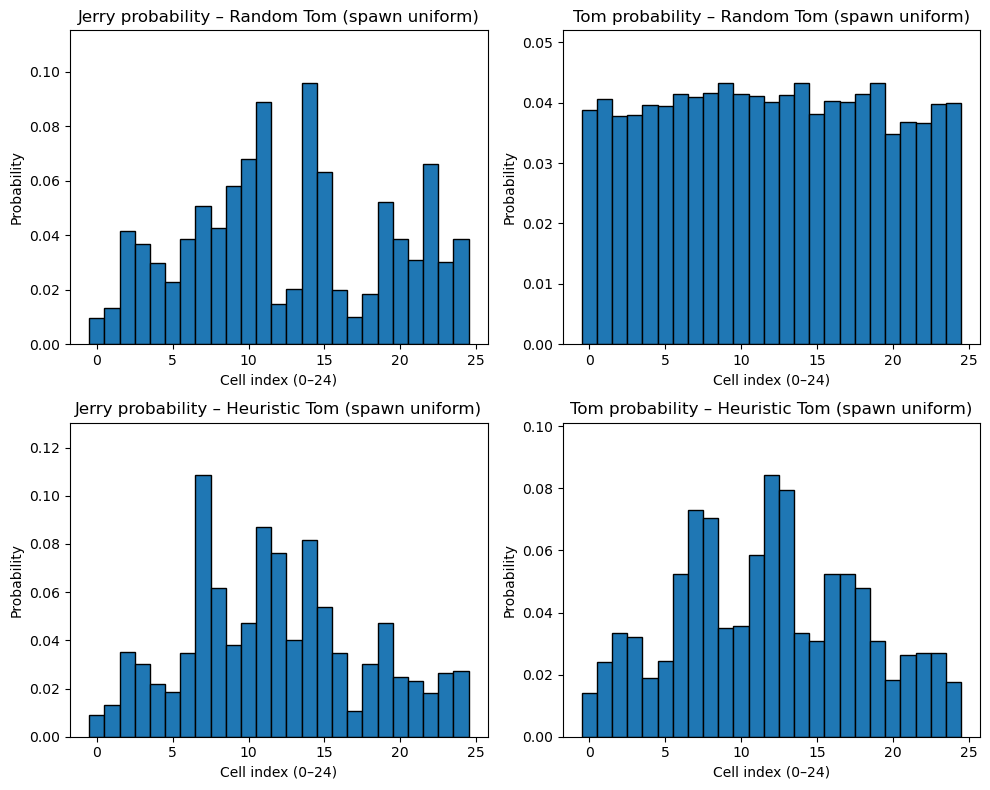

In [4]:
    # -------------------------------------------------
    # new experiment: random spawns + 1D probability histograms
    # -------------------------------------------------
    print("\nRunning extra experiment: random spawns + histograms (probabilities)...")

    def simulate_with_random_spawns(policy, tom_policy, chase_p=0.7,
                                    num_episodes=10_000, max_steps=100):
        """
        Simulate episodes where BOTH Jerry and Tom start from
        uniformly random grid cells (0..24), independent each episode.
        Returns:
            jerry_probs: length-25 array of visit probabilities for Jerry.
            tom_probs:   length-25 array of visit probabilities for Tom.
        """
        jerry_counts = np.zeros(NUM_CELLS, dtype=int)
        tom_counts = np.zeros(NUM_CELLS, dtype=int)

        rng = np.random.default_rng(0)  # reproducible independent RNG

        for _ in range(num_episodes):
            # Uniform random spawn for both agents
            j = rng.integers(NUM_CELLS)
            t = rng.integers(NUM_CELLS)

            for _ in range(max_steps):
                jerry_counts[j] += 1
                tom_counts[t] += 1

                if is_goal_state(j, t) or is_bad_state(j, t):
                    break

                s = encode_state(j, t)
                a = policy[s]
                if a == -1:
                    break

                # Jerry transition
                j_probs_dict = jerry_transition_probs(j, a)
                j_next = np.array(list(j_probs_dict.keys()))
                j_p     = np.array(list(j_probs_dict.values()))
                j_p    /= j_p.sum()
                j = rng.choice(j_next, p=j_p)

                # Tom transition
                if tom_policy == 'random':
                    t_probs_dict = tom_transition_probs_random(t)
                elif tom_policy == 'heuristic':
                    t_probs_dict = tom_transition_probs_heuristic(t, j, chase_p=chase_p)
                else:
                    raise ValueError(f"Unknown tom_policy: {tom_policy}")

                t_next = np.array(list(t_probs_dict.keys()))
                t_p    = np.array(list(t_probs_dict.values()))
                t_p   /= t_p.sum()
                t = rng.choice(t_next, p=t_p)

        # Convert counts → probabilities
        jerry_probs = jerry_counts / jerry_counts.sum()
        tom_probs   = tom_counts   / tom_counts.sum()

        return jerry_probs, tom_probs


    # Run simulations for Random Tom
    jerry_probs_randomTom, tom_probs_randomTom = simulate_with_random_spawns(
        policy_random, tom_policy='random', num_episodes=10_000, max_steps=100
    )

    # Run simulations for Heuristic Tom
    jerry_probs_heurTom, tom_probs_heurTom = simulate_with_random_spawns(
        policy_heuristic, tom_policy='heuristic', chase_p=0.7,
        num_episodes=10_000, max_steps=100
    )


    # -------------------------------------------------
    # Plot 1D probability histograms
    # -------------------------------------------------
    def plot_state_histograms_1d(jerry_random, tom_random, jerry_heur, tom_heur):
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))

        states = np.arange(NUM_CELLS)
        bins = np.arange(NUM_CELLS + 1) - 0.5

        def show_hist(ax, probs, title):
            ax.hist(states, bins=bins, weights=probs, edgecolor='black')
            ax.set_title(title)
            ax.set_xlabel("Cell index (0–24)")
            ax.set_ylabel("Probability")
            ax.set_ylim(0, probs.max() * 1.2)

        show_hist(axes[0, 0], jerry_random, "Jerry probability – Random Tom (spawn uniform)")
        show_hist(axes[0, 1], tom_random,   "Tom probability – Random Tom (spawn uniform)")
        show_hist(axes[1, 0], jerry_heur,   "Jerry probability – Heuristic Tom (spawn uniform)")
        show_hist(axes[1, 1], tom_heur,     "Tom probability – Heuristic Tom (spawn uniform)")

        plt.tight_layout()
        plt.show()


    print("Rendering 1D probability histograms...")
    plot_state_histograms_1d(
        jerry_probs_randomTom,
        tom_probs_randomTom,
        jerry_probs_heurTom,
        tom_probs_heurTom,
    )



Rendering 2D probability heatmaps...


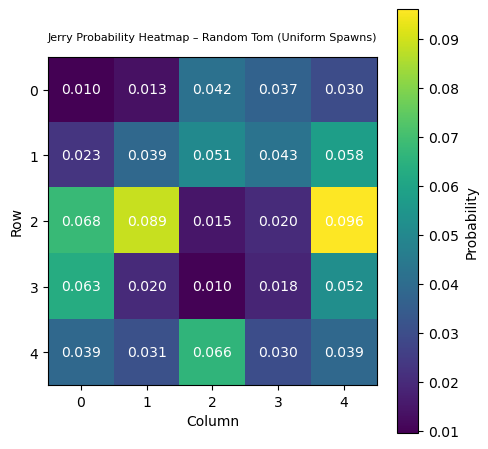

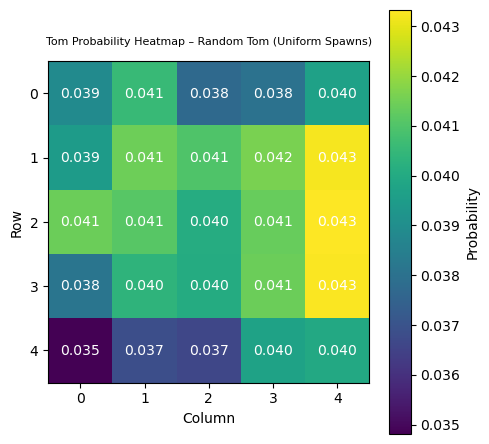

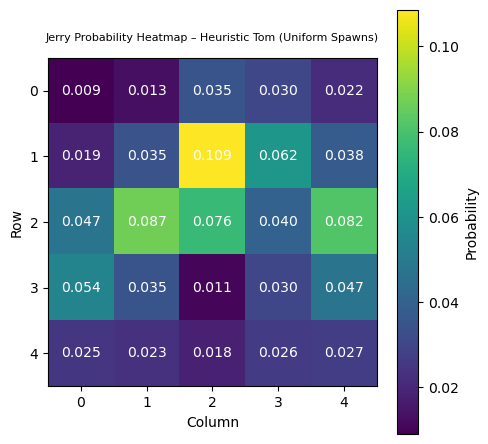

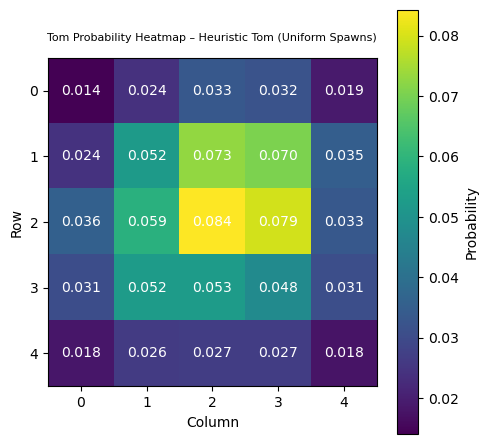

In [8]:
# -------------------------------------------------
# 2D HEATMAPS — PROBABILITY DISTRIBUTIONS OVER GRID
# -------------------------------------------------

def plot_heatmap(prob_vector, title):
    grid = prob_vector.reshape(GRID_SIZE, GRID_SIZE)

    plt.figure(figsize=(5, 5))
    plt.imshow(grid, cmap='viridis', origin='upper')
    plt.colorbar(label="Probability")

    # Multi-line title + smaller font
    plt.title(title, fontsize=8, pad=12)

    plt.xlabel("Column")
    plt.ylabel("Row")

    # Annotate probabilities
    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            plt.text(c, r, f"{grid[r,c]:.3f}",
                     ha='center', va='center', color='white')

    # Add padding so title doesn't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()



print("\nRendering 2D probability heatmaps...")

plot_heatmap(jerry_probs_randomTom,
             "Jerry Probability Heatmap – Random Tom (Uniform Spawns)")
plot_heatmap(tom_probs_randomTom,
             "Tom Probability Heatmap – Random Tom (Uniform Spawns)")

plot_heatmap(jerry_probs_heurTom,
             "Jerry Probability Heatmap – Heuristic Tom (Uniform Spawns)")
plot_heatmap(tom_probs_heurTom,
             "Tom Probability Heatmap – Heuristic Tom (Uniform Spawns)")



Estimating joint state distributions for (Jerry, Tom)...
Rendering joint (Jerry, Tom) probability heatmaps...


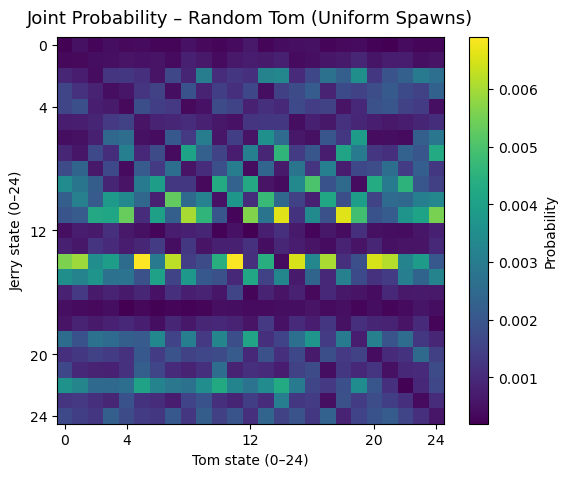

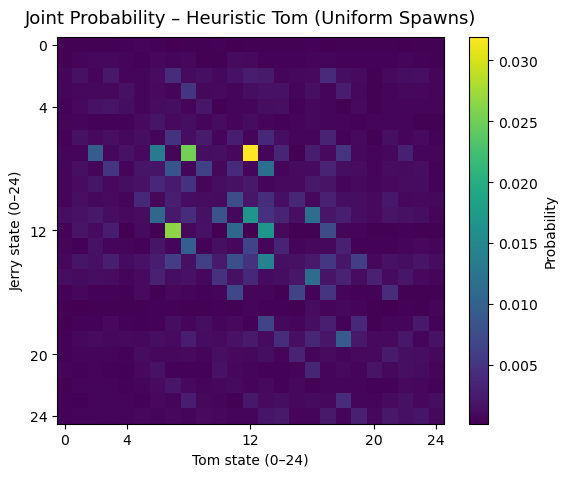

In [9]:
    # -------------------------------------------------
    # Joint state distributions: P(Jerry=j, Tom=t)
    # -------------------------------------------------
    print("\nEstimating joint state distributions for (Jerry, Tom)...")

    def simulate_joint_with_random_spawns(policy, tom_policy, chase_p=0.7,
                                          num_episodes=10_000, max_steps=100):
        """
        Simulate episodes where BOTH Jerry and Tom start from
        uniformly random grid cells (0..24), independent each episode.
        Returns:
            joint_probs: (25 x 25) array where [j, t] = P(Jerry=j, Tom=t).
        """
        joint_counts = np.zeros((NUM_CELLS, NUM_CELLS), dtype=int)
        rng = np.random.default_rng(123)  # separate RNG for this experiment

        for _ in range(num_episodes):
            # Uniform random spawn for both agents
            j = rng.integers(NUM_CELLS)
            t = rng.integers(NUM_CELLS)

            for _ in range(max_steps):
                # Update joint visit count
                joint_counts[j, t] += 1

                if is_goal_state(j, t) or is_bad_state(j, t):
                    break

                s = encode_state(j, t)
                a = policy[s]
                if a == -1:
                    break

                # Sample Jerry's next position
                j_probs_dict = jerry_transition_probs(j, a)
                j_next_states = np.array(list(j_probs_dict.keys()))
                j_probs = np.array(list(j_probs_dict.values()), dtype=float)
                j_probs /= j_probs.sum()
                j = rng.choice(j_next_states, p=j_probs)

                # Sample Tom's next position
                if tom_policy == 'random':
                    t_probs_dict = tom_transition_probs_random(t)
                elif tom_policy == 'heuristic':
                    t_probs_dict = tom_transition_probs_heuristic(t, j, chase_p=chase_p)
                else:
                    raise ValueError(f"Unknown tom_policy: {tom_policy}")

                t_next_states = np.array(list(t_probs_dict.keys()))
                t_probs = np.array(list(t_probs_dict.values()), dtype=float)
                t_probs /= t_probs.sum()
                t = rng.choice(t_next_states, p=t_probs)

        total = joint_counts.sum()
        joint_probs = joint_counts / total if total > 0 else joint_counts.astype(float)
        return joint_probs


    def plot_joint_heatmap(joint_probs, title):
        """
        joint_probs: 25x25 array where rows = Jerry state, cols = Tom state.
        """
        plt.figure(figsize=(6, 5))
        im = plt.imshow(joint_probs, cmap='viridis', origin='upper')
        plt.colorbar(im, label="Probability")
        plt.title(title, fontsize=13, pad=10)
        plt.xlabel("Tom state (0–24)")
        plt.ylabel("Jerry state (0–24)")

        #fewer ticks so it’s readable
        ticks = [0, 4, 12, 20, 24]
        plt.xticks(ticks)
        plt.yticks(ticks)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


    # Run joint simulations for each Tom model
    joint_probs_randomTom = simulate_joint_with_random_spawns(
        policy_random, tom_policy='random', num_episodes=10_000, max_steps=100
    )
    joint_probs_heurTom = simulate_joint_with_random_spawns(
        policy_heuristic, tom_policy='heuristic', chase_p=0.7,
        num_episodes=10_000, max_steps=100
    )

    print("Rendering joint (Jerry, Tom) probability heatmaps...")
    plot_joint_heatmap(joint_probs_randomTom,
                       "Joint Probability – Random Tom (Uniform Spawns)")
    plot_joint_heatmap(joint_probs_heurTom,
                       "Joint Probability – Heuristic Tom (Uniform Spawns)")
